chemLTD WT vs. mutant
=====================

Two florophore (CFP + EYFP) data analysis. Two emission channels (DX505) + two excitation wls. (435 nm + 505 nm)

In [113]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io
from skimage import transform
from skimage import registration

from scipy import ndimage
from scipy import signal
from scipy import stats
from scipy import ndimage as ndi


### Cmaps

In [114]:
# CFP cmap
dict_cyan = {'red':(
             (0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
             'blue':(
             (0.0, 0.0, 0.0),
             (1.0, 1.0, 1.0)),
             'green':(
             (0.0, 0.0, 0.0),
             (1.0, 1.0, 1.0))}
cmap_cyan = LinearSegmentedColormap('Cyan', dict_cyan)

# YFP cmap
dict_yellow = {'red':(
               (0.0, 0.0, 0.0),
               (1.0, 1.0, 1.0)),
               'blue':(
               (0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
               'green':(
               (0.0, 0.0, 0.0),
               (1.0, 1.0, 1.0))}
cmap_yellow = LinearSegmentedColormap('Yellow', dict_yellow)

# red-green cmap creation
dict_red_green = {'red':(
                   (0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.55, 0.3, 0.7),
                   (1.0, 1.0, 1.0)),
                   'blue':(
                   (0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
                   'green':(
                   (0.0, 1.0, 1.0),
                   (0.45, 0.7, 0.3),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}
cmap_red_green = LinearSegmentedColormap('RedGreen', dict_red_green)

# only red cmap
dict_red = {'red':(
             (0.0, 1.0, 1.0),
             (1.0, 1.0, 0.0)),
             'blue':(
             (0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
             'green':(
             (0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0))}
cmap_red = LinearSegmentedColormap('red', dict_red)


def plot_linearmap(cdict):
    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
    rgba = newcmp(np.linspace(0, 1, 256))
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    col = ['r', 'g', 'b']
    for xx in [0.25, 0.5, 0.75]:
        ax.axvline(xx, color='0.7', linestyle='--')
    for i in range(3):
        ax.plot(np.arange(256)/256, rgba[:, i], color=col[i])
    ax.set_xlabel('index')
    ax.set_ylabel('RGB')
    plt.show()
# plot_linearmap(dict_red)

## Img upload

#### Channels review

(50, 1040, 696, 4)


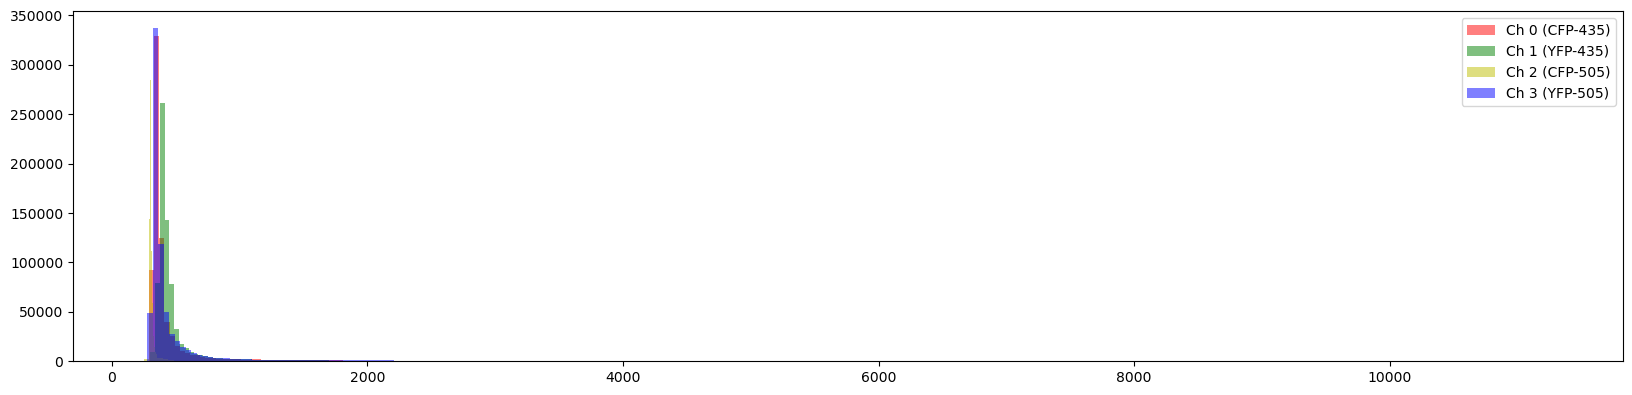

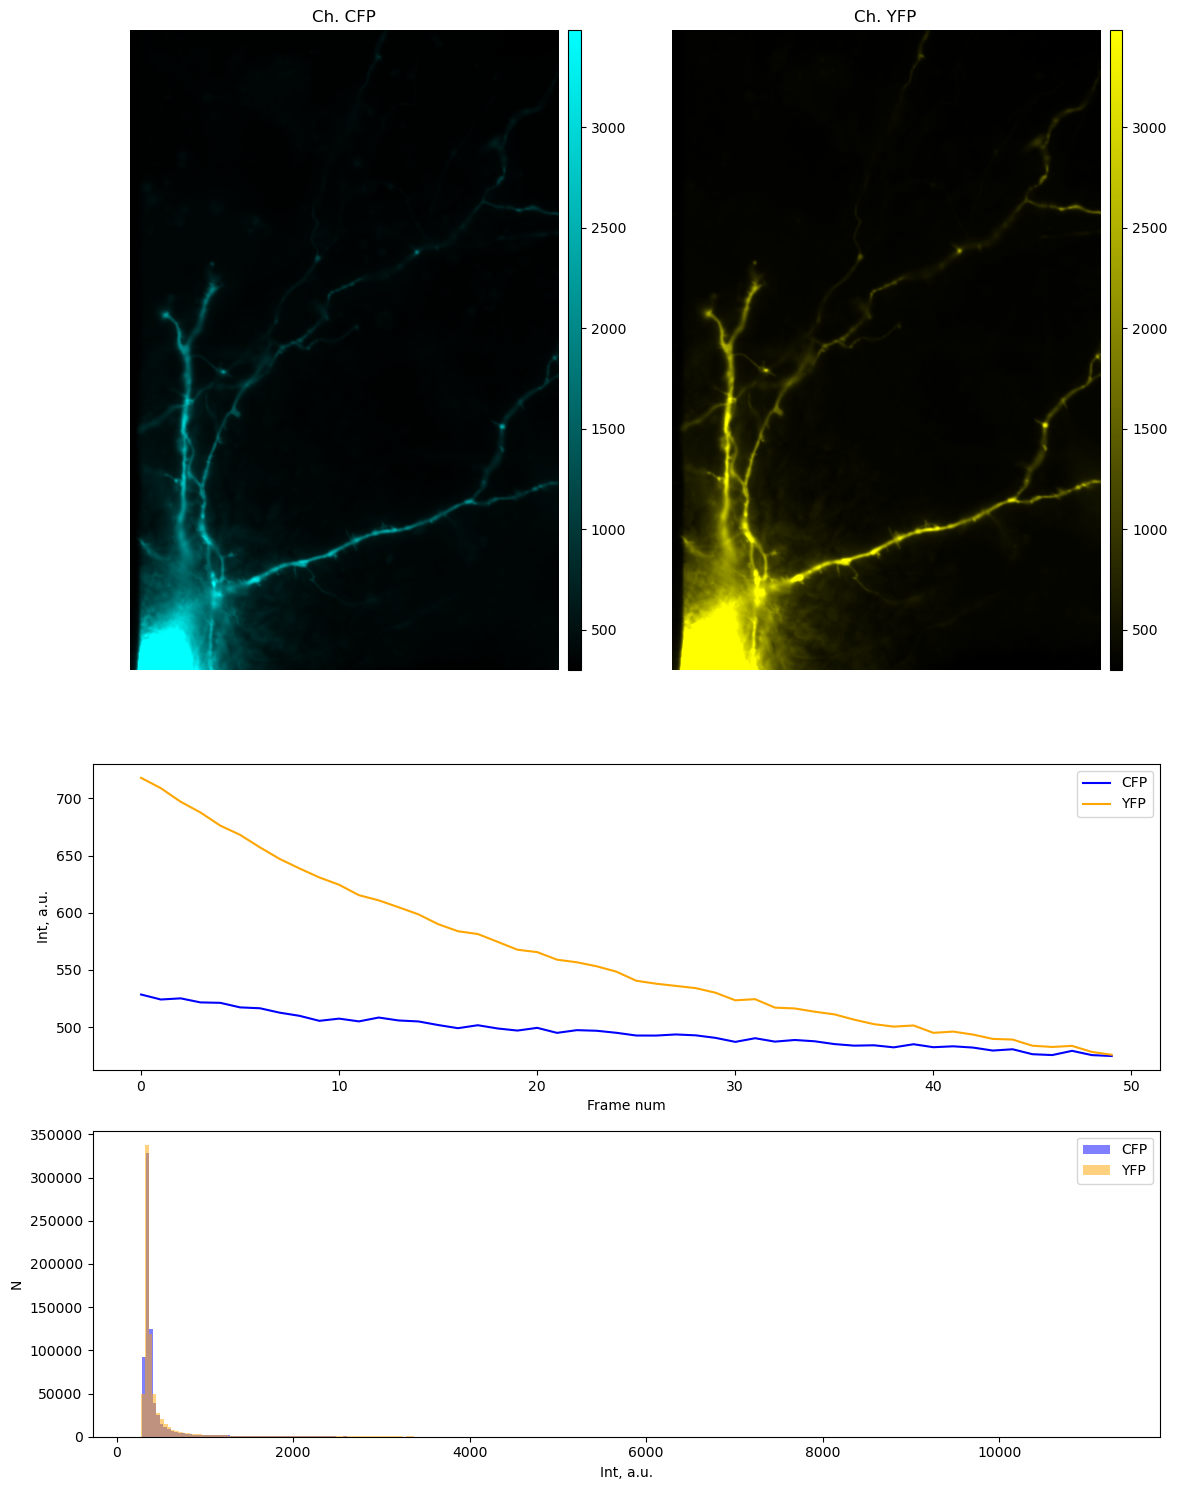

In [115]:
img_name = '11_good.tif'
samp_name = img_name.split('.')[0]
img_raw = io.imread(img_name)
print(img_raw.shape)

img_cfp_raw = img_raw[:,:,:,0]
img_yfp_raw = img_raw[:,:,:,3]

ch0_ctrl = np.mean(img_raw[:,:,:,0], axis=0)
ch1_ctrl = np.mean(img_raw[:,:,:,1], axis=0)
ch2_ctrl = np.mean(img_raw[:,:,:,2], axis=0)
ch3_ctrl = np.mean(img_raw[:,:,:,3], axis=0)


plt.figure(figsize=(20,10))

ax0 = plt.subplot(211)
ax0.hist(ch0_ctrl.ravel(), bins=256, alpha=.5, label='Ch 0 (CFP-435)', color='r')
ax0.hist(ch1_ctrl.ravel(), bins=256, alpha=.5, label='Ch 1 (YFP-435)', color='g')
ax0.hist(ch2_ctrl.ravel(), bins=256, alpha=.5, label='Ch 2 (CFP-505)', color='y')
ax0.hist(ch3_ctrl.ravel(), bins=256, alpha=.5, label='Ch 3 (YFP-505)', color='b')
ax0.legend()

plt.show()


img_cfp_ctrl = np.mean(img_cfp_raw, axis=0)
img_yfp_ctrl = np.mean(img_yfp_raw, axis=0)

img_cfp = filters.gaussian(img_cfp_raw, sigma=0.5)
img_yfp = filters.gaussian(img_yfp_raw, sigma=0.5)

img_cfp_series_mean = np.mean(img_cfp, axis=0)
img_yfp_series_mean = np.mean(img_yfp, axis=0)

ctrl_img_int_min, ctrl_img_int_max = 300, np.max(img_raw)*0.3


plt.figure(figsize=(12,15))
ax0 = plt.subplot(221)
ax0.set_title('Ch. CFP')
img0 = ax0.imshow(img_cfp_ctrl, cmap=cmap_cyan)
img0.set_clim(vmin=ctrl_img_int_min, vmax=ctrl_img_int_max)
div0 = make_axes_locatable(ax0)
cax0 = div0.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img0, cax=cax0)
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.set_title('Ch. YFP')
img1 = ax1.imshow(img_yfp_ctrl, cmap=cmap_yellow)
img1.set_clim(vmin=ctrl_img_int_min, vmax=ctrl_img_int_max)
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img1, cax=cax1)
ax1.axis('off')

ax2 = plt.subplot(413)
ax2.plot(np.mean(img_cfp_raw, axis=(1,2)), label='CFP', color='blue')
ax2.plot(np.mean(img_yfp_raw, axis=(1,2)), label='YFP', color='orange')
ax2.set_xlabel('Frame num')
ax2.set_ylabel('Int, a.u.')
ax2.legend()

ax3 = plt.subplot(414)
ax3.hist(img_cfp_ctrl.ravel(), bins=256, alpha=.5, label='CFP', color='blue')
ax3.hist(img_yfp_ctrl.ravel(), bins=256, alpha=.5, label='YFP', color='orange')
ax3.set_xlabel('Int, a.u.')
ax3.set_ylabel('N')
ax3.legend()

plt.tight_layout()
plt.show()

#### Movements correction

In [116]:
# NOT WORKING!!!


# r_input = np.asarray(img_cfp_series_mean, dtype='float')
# r_input = (r_input - np.min(r_input)) / (np.max(r_input) - np.min(r_input))

# g_input = np.asarray(img_yfp_series_mean, dtype='float')
# g_input = (g_input - np.min(g_input)) / (np.max(g_input) - np.min(g_input))

# b_zeros = np.zeros_like(r_input, dtype='float')

# rgb_input = np.stack([r_input, g_input, b_zeros], axis=-1)


# v, u = registration.optical_flow_tvl1(r_input, g_input)

# r_row, r_col = r_input.shape
# r_row_coords, r_col_coords = np.meshgrid(np.arange(r_row), np.arange(r_col), indexing='ij')

# g_input_warp = transform.warp(g_input, np.array([r_row_coords+v, r_col_coords+u]), mode='edge')

# rgb_warped = np.stack([r_input, g_input_warp, b_zeros], axis=-1)


# plt.figure(figsize=(20,20))
# ax0 = plt.subplot(121)
# ax0.imshow(rgb_input)
# ax0.axis('off')

# ax1 = plt.subplot(122)
# ax1.imshow(rgb_warped)
# ax1.axis('off')

## Masking and application frame detection

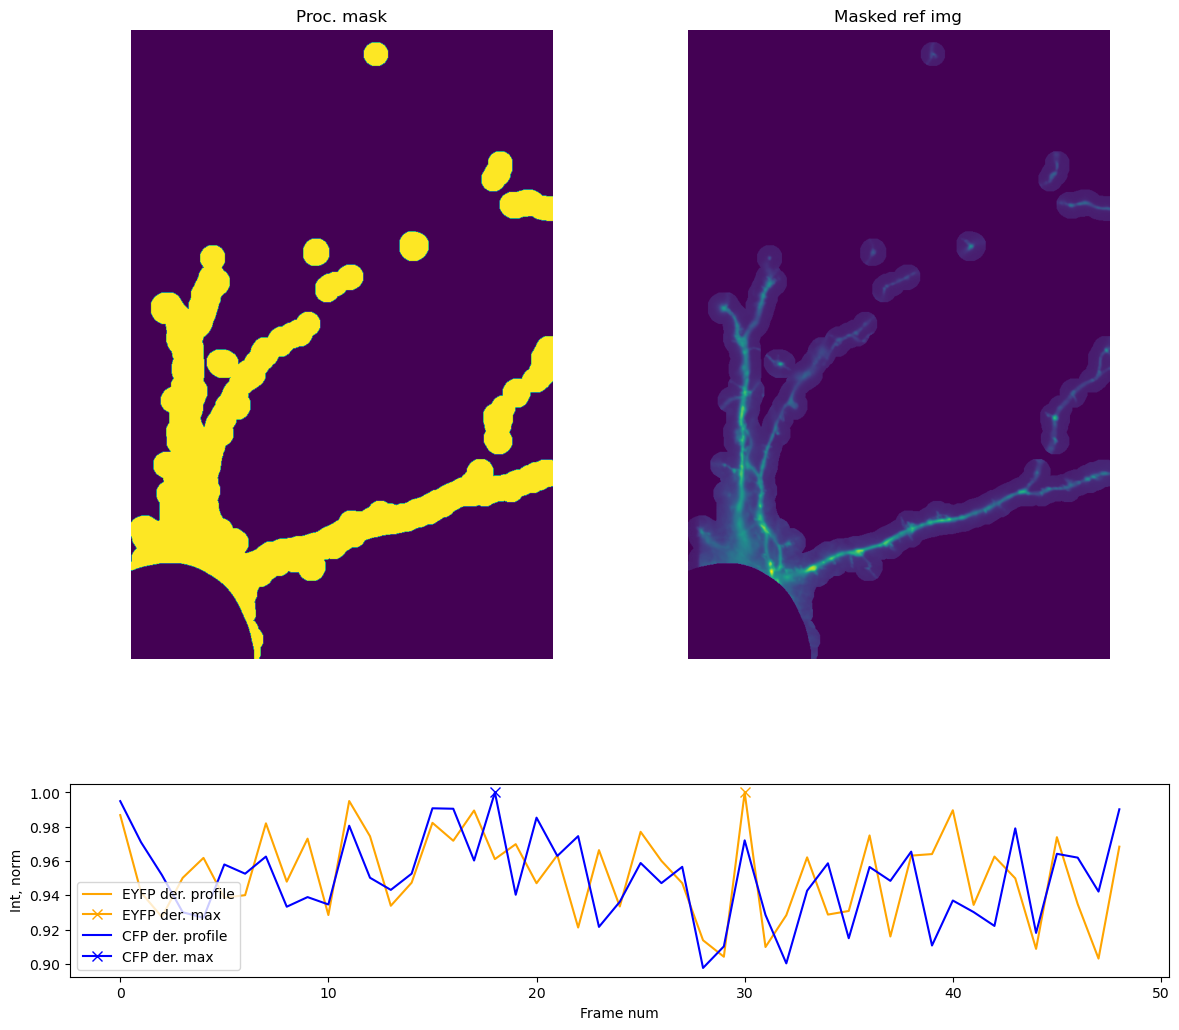

In [117]:
def cell_masking(input_img, soma_mask=True, soma_th=0.5, soma_ext=20, proc_ext=5):
    # soma masking
    if soma_mask:
        soma_region = np.copy(input_img)
        soma_region = soma_region > soma_region.max() * soma_th
        soma_region = morphology.opening(soma_region, footprint=morphology.disk(5))
        # soma_region = morphology.dilation(soma_region, footprint=morphology.disk(10))
        soma_dist = ndimage.distance_transform_edt(~soma_region, return_indices=False)
        soma_mask = soma_dist < soma_ext
        input_img = ma.masked_where(soma_mask, input_img)

        th = filters.threshold_otsu(input_img.compressed())
    else:
        th = filters.threshold_otsu(input_img)

    # processes masking
    proc_mask = input_img > th
    proc_mask = morphology.closing(proc_mask, footprint=morphology.disk(5))
    proc_dist = ndimage.distance_transform_edt(~proc_mask, return_indices=False)
    proc_mask_fin = proc_dist < proc_ext
    proc_mask_fin[soma_mask] = 0

    return proc_mask_fin

img_ctrl_max = np.max(img_yfp, axis=0)

mask = cell_masking(img_ctrl_max, soma_mask=True, soma_th=0.75, soma_ext=100, proc_ext=20)
mask_arr = np.asarray([z+mask for z in np.zeros_like(img_yfp)], dtype='bool')

# maskings
img_yfp_masked = np.copy(img_yfp)
img_yfp_masked[~mask_arr] = 0

img_cfp_masked = np.copy(img_cfp)
img_cfp_masked[~mask_arr] = 0

# pb corr with constant val
img_yfp_masked = np.asarray([img * (np.sum(np.mean(img_yfp_masked[:2], axis=0)/np.sum(img))) for img in img_yfp_masked])
img_cfp_masked = np.asarray([img * (np.sum(np.mean(img_cfp_masked[:2], axis=0)/np.sum(img))) for img in img_cfp_masked])


def der_prof_calc(input_img_series):
    input_series_mean_prof = np.mean(input_img_series, axis=(1, 2))
    input_series_mean_prof_norm = input_series_mean_prof / input_series_mean_prof.max()

    input_series_der_prof = np.asarray([np.sum(np.abs(img)) for img in (input_img_series[:-1] - input_img_series[1:])])
    input_series_der_prof_norm = input_series_der_prof / input_series_der_prof.max()

    der_max_idx = np.argmax(input_series_der_prof_norm)

    return input_series_der_prof_norm, der_max_idx

yfp_der_prof, yfp_der_max = der_prof_calc(img_yfp_masked)
cfp_der_prof, cfp_der_max = der_prof_calc(img_cfp_masked)


plt.figure(figsize=(12,15))
ax0 = plt.subplot(221)
ax0.set_title('Proc. mask')
ax0.imshow(mask)
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.set_title('Masked ref img')
ax1.imshow(np.max(img_yfp_masked, axis=0))
ax1.axis('off')

ax2 = plt.subplot(614)
ax2.plot(yfp_der_prof, label='EYFP der. profile', color='orange')
ax2.plot(yfp_der_max, yfp_der_prof[yfp_der_max], marker='x', markersize=7, color='orange', label='EYFP der. max')
ax2.plot(cfp_der_prof, label='CFP der. profile', color='blue')
ax2.plot(cfp_der_max, cfp_der_prof[cfp_der_max], marker='x', markersize=7, color='blue', label='CFP der. max')

plt.xlabel('Frame num')
plt.ylabel('Int, norm')

plt.legend()
plt.tight_layout()
plt.show()

## Red-green mask creation

In [118]:
base_frames = 5

app_frame = 7
app_shift = 5

#### Diff img & up mask calc

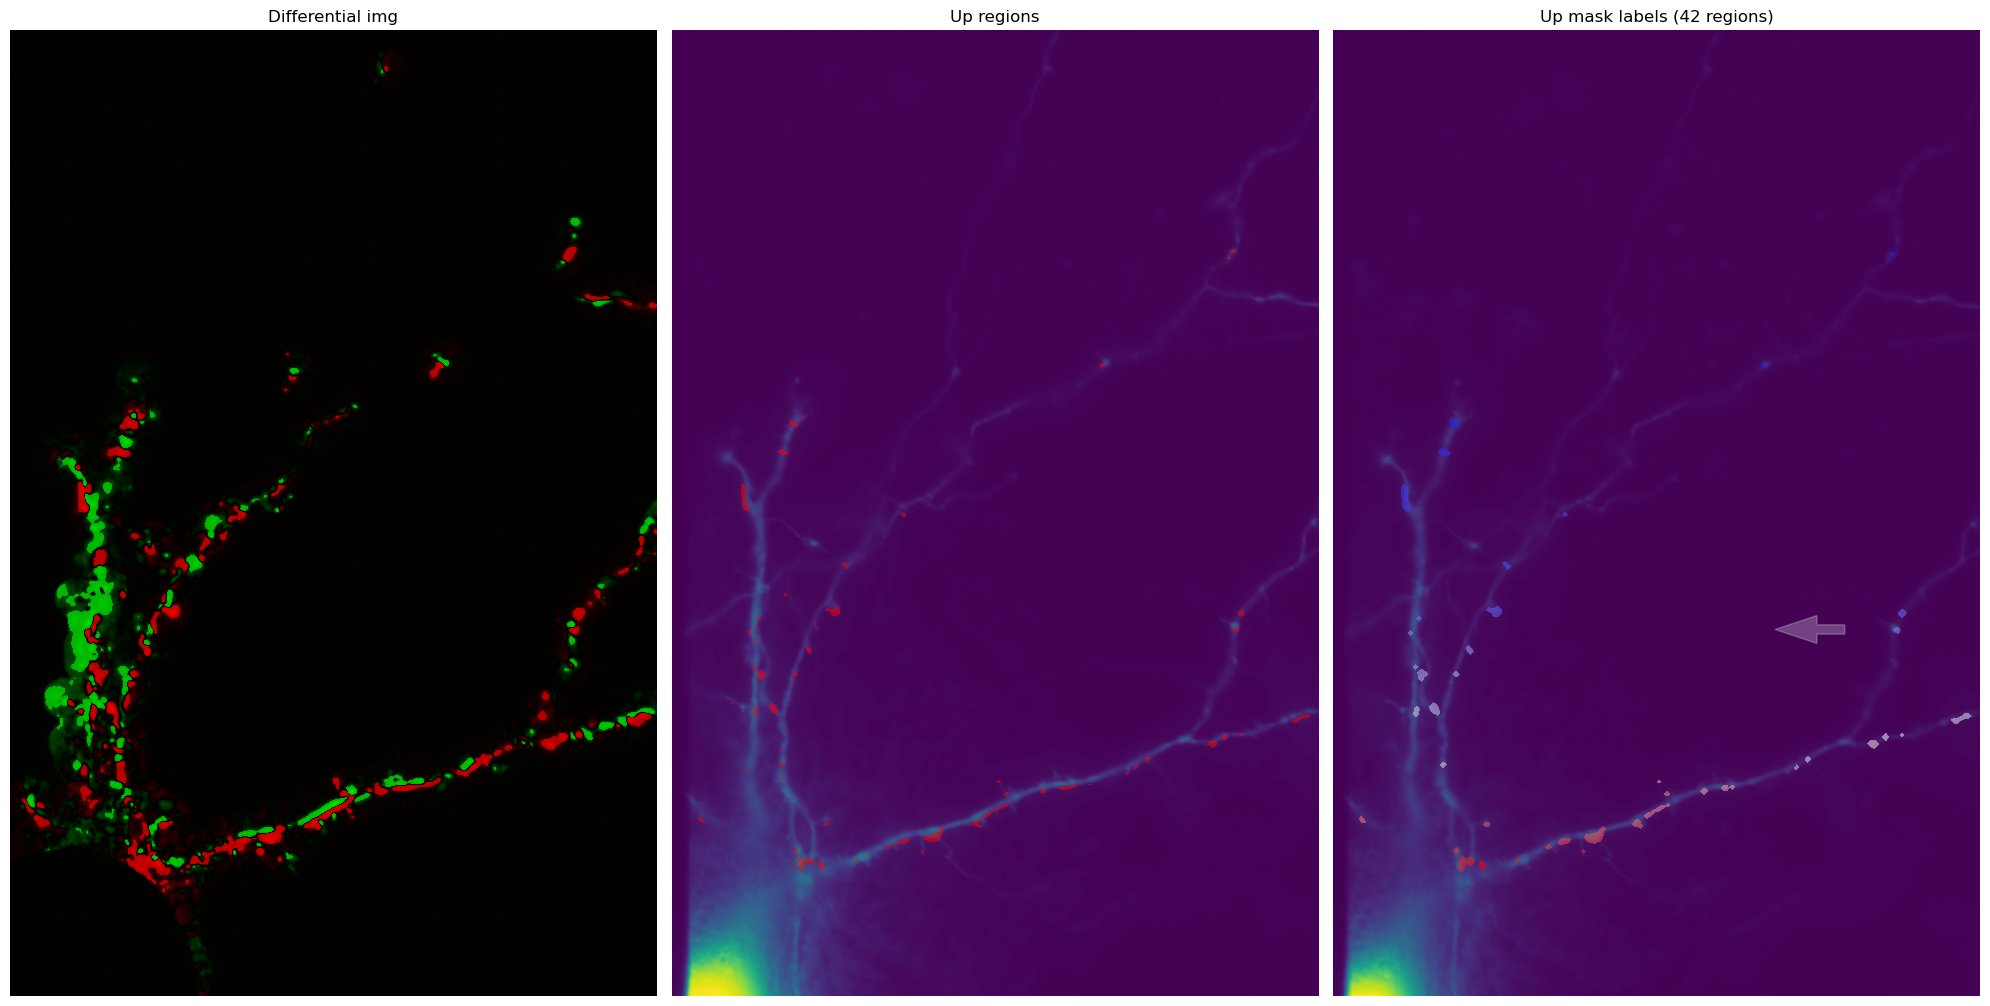

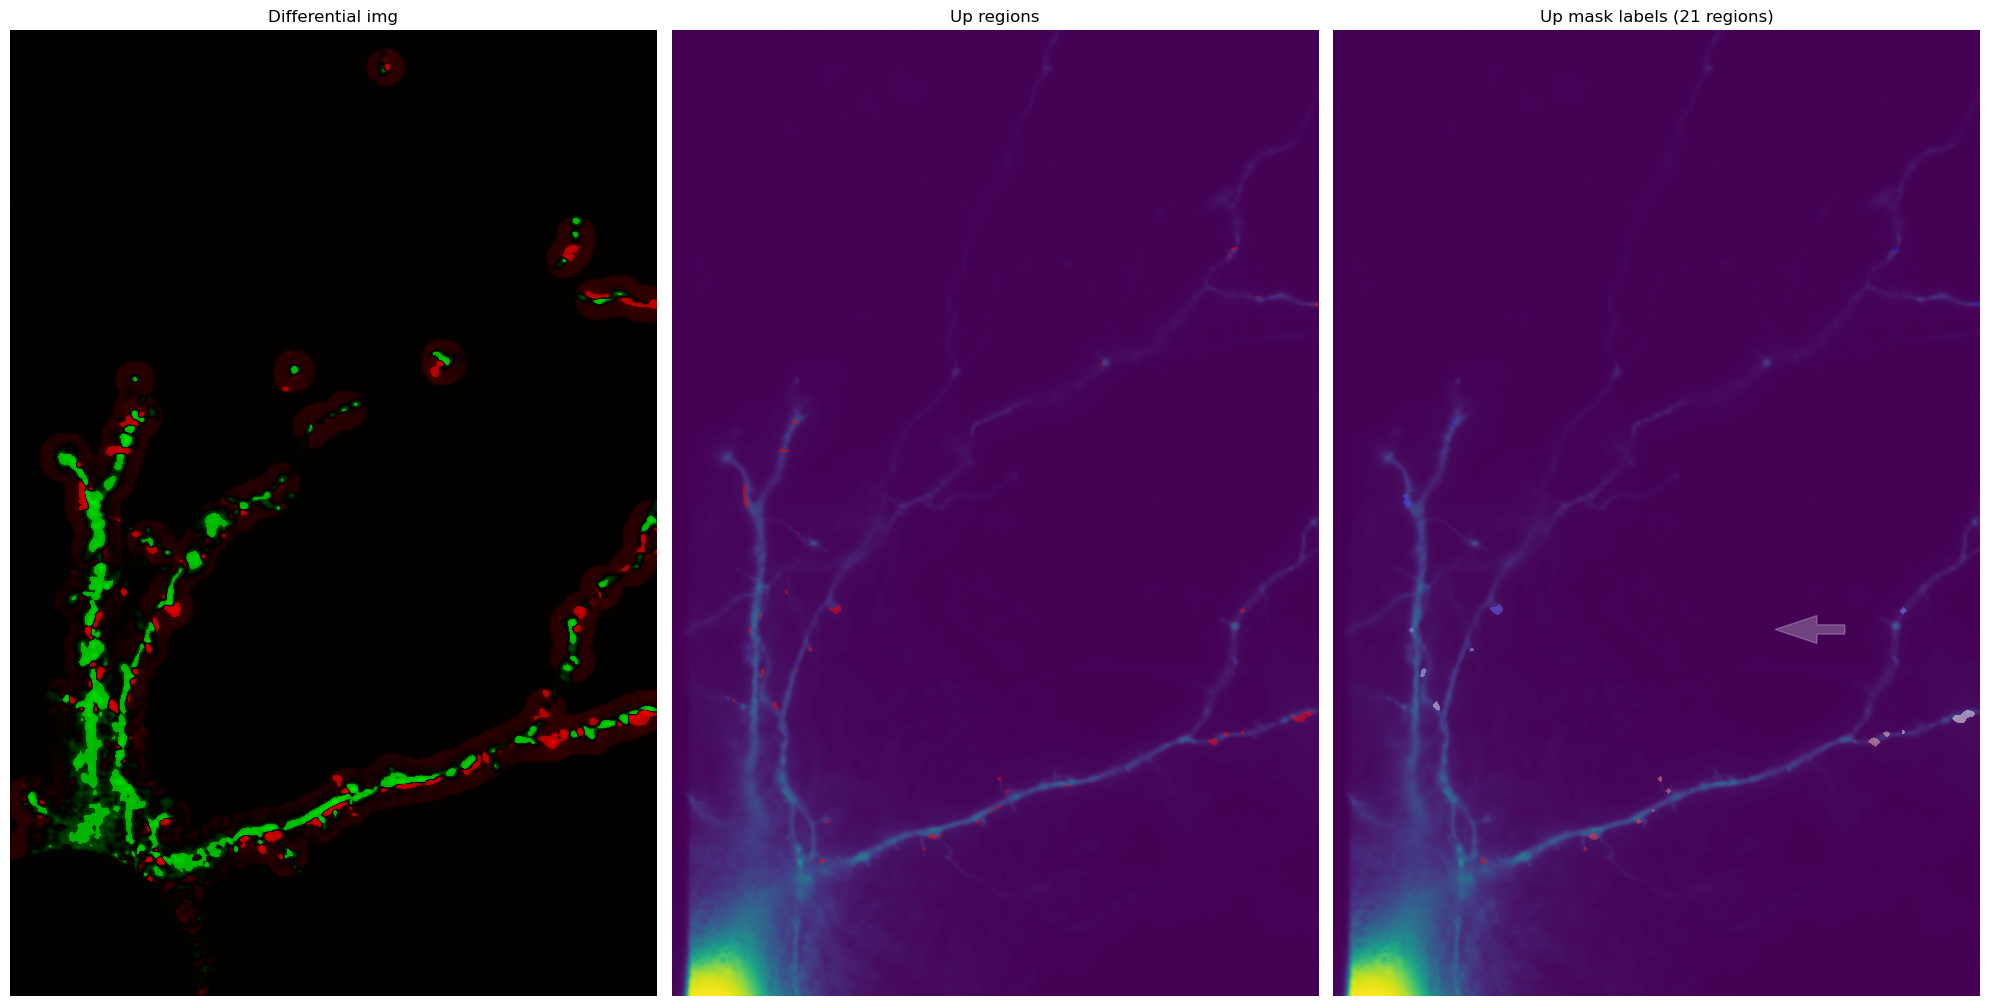

In [119]:
def up_mask_calc(input_img_series, ctrl_img, base_frames=5, app_start=7, app_win=5):
    ref_img_series = filters.gaussian(input_img_series, sigma=1.25, channel_axis=0)

    img_base = np.mean(ref_img_series[:base_frames], axis=0)
    img_max = np.mean(ref_img_series[app_start:app_start+app_win], axis=0)

    img_diff = img_max - img_base
    img_diff = img_diff/np.max(np.abs(img_diff))

    diff_sd = np.std(ma.masked_where(~mask, img_diff))
    up_mask = img_diff > diff_sd * 2

    up_mask_filt = morphology.opening(up_mask, footprint=morphology.disk(2))
    up_mask_filt = morphology.dilation(up_mask_filt, footprint=morphology.disk(1))
    up_label = measure.label(up_mask_filt)


    plt.figure(figsize=(20,20))
    ax0 = plt.subplot(131)
    ax0.set_title('Differential img')
    ax0.imshow(img_diff, cmap=cmap_red_green, vmax=1, vmin=-1)
    ax0.axis('off')

    ax1 = plt.subplot(132)
    ax1.set_title('Up regions')
    ax1.imshow(img_yfp_ctrl)
    ax1.imshow(ma.masked_where(~up_mask, up_mask), alpha=0.5, cmap=cmap_red)
    ax1.axis('off')

    ax2 = plt.subplot(133)
    ax2.set_title(f'Up mask labels ({up_label.max()} regions)')
    ax2.imshow(ctrl_img)
    ax2.imshow(ma.masked_where(~up_mask_filt, up_label), alpha=0.5, cmap='bwr')
    ax2.arrow(550,645,-30,0,width=10, alpha=0.25, color='white')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return up_mask_filt, up_label, img_diff


cfp_up_mask, cfp_up_label, cfp_diff_img = up_mask_calc(img_cfp_masked, img_cfp_ctrl)
yfp_up_mask, yfp_up_label, yfp_diff_img = up_mask_calc(img_yfp_masked, img_yfp_ctrl)

#### Up masks comparison. CFP vs. YFP

(-0.5, 695.5, 1039.5, -0.5)

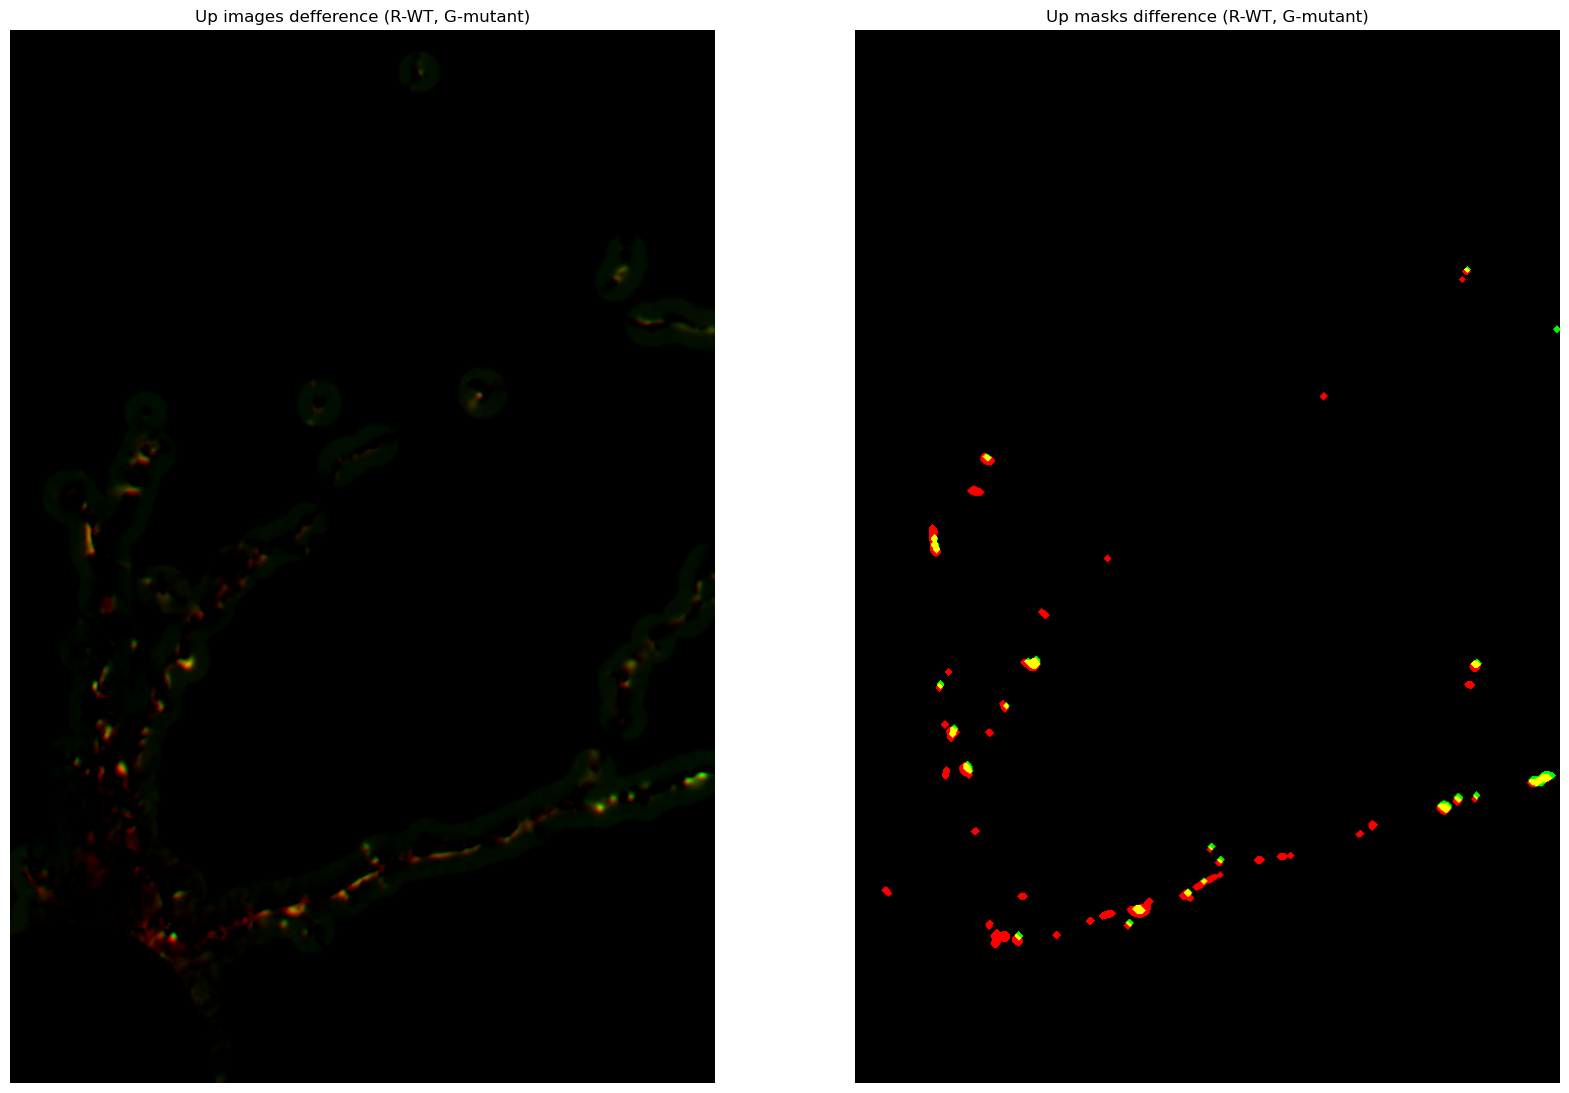

In [120]:
def up_mask_connection(input_wt_mask, input_mutant_mask):
    wt_label, wt_num = ndi.label(input_wt_mask)

    sums = ndi.sum(input_mutant_mask, wt_label, np.arange(wt_num+1))
    connected = sums > 0
    debris_mask = connected[wt_label]

    fin_mask = np.copy(input_wt_mask)
    fin_mask[~debris_mask] = 0

    fin_label, fin_num = ndi.label(fin_mask)

    return fin_mask, fin_label

# WT ROIs which overlay with mutant ROIs
connected_up_mask, connected_up_label = up_mask_connection(cfp_up_mask, yfp_up_mask)

# connected WT ROIs wihout mutant ROIs
halo_up_mask = np.copy(connected_up_mask)
halo_up_mask[yfp_up_mask] = 0
halo_up_label, halo_up_num = ndi.label(halo_up_mask)

# murant ROIs in WT ROIs
mutant_up_mask = np.copy(yfp_up_mask)
mutant_up_mask[~connected_up_mask] = 0
mutant_up_label, mutant_up_num = ndi.label(mutant_up_mask)


# RGB ctrl img creation
yfp_diff_gray = np.copy(yfp_diff_img)
cfp_diff_gray = np.copy(cfp_diff_img)

yfp_diff_gray[yfp_diff_gray < 0] = 0
cfp_diff_gray[cfp_diff_gray < 0] = 0

r_up = np.asarray(cfp_diff_gray, dtype='float')
r_up_norm = (r_up - np.min(r_up)) / (np.max(r_up) - np.min(r_up))
g_up = np.asarray(yfp_diff_gray, dtype='float')
g_up_norm = (g_up - np.min(g_up)) / (np.max(g_up) - np.min(g_up))

r_mask = np.asarray(cfp_up_mask, dtype='float')
g_mask = np.asarray(yfp_up_mask, dtype='float')

b_zeros = np.asarray(np.zeros_like(cfp_up_mask), dtype='float')

up_diff = np.stack((r_up_norm, g_up_norm, b_zeros), axis=-1)
mask_diff = np.stack((r_mask, g_mask, b_zeros), axis=-1)


plt.figure(figsize=(20,20))
ax0 = plt.subplot(121)
ax0.set_title('Up images defference (R-WT, G-mutant)')
ax0.imshow(up_diff)
ax0.axis('off')

ax1 = plt.subplot(122)
ax1.set_title('Up masks difference (R-WT, G-mutant)')
ax1.imshow(mask_diff)
ax1.axis('off')

#### Up regions distance calc

In [121]:
def label_prof_calc(input_labels, input_img_series, input_dist_img):
    output_dict = {}
    for label_num in range(1, np.max(input_labels)+1):
        region_mask = input_labels == label_num
        prof = np.asarray([np.mean(ma.masked_where(~region_mask, img)) for img in input_img_series])
        F_0 = np.mean(prof[:5])
        df_prof = (prof-F_0)/F_0
        dist = round(np.mean(ma.masked_where(~region_mask, input_dist_img)), 1)
        output_dict.update({dist:[label_num, prof, df_prof]})
    
    return output_dict


# pipett tip position mask
pipet_mask = np.ones_like(img_yfp_ctrl)
pipet_mask[645, 480] = 0
pipet_dist_img = ndi.distance_transform_edt(pipet_mask)


con_dist_img = ma.masked_where(~connected_up_mask, pipet_dist_img)
hal_dist_img = ma.masked_where(~halo_up_mask, pipet_dist_img)
mut_dist_img = ma.masked_where(~mutant_up_mask, pipet_dist_img)
# yfp_dist_img = ma.masked_where(~yfp_up_mask, pipet_dist_img)
# cfp_dist_img = ma.masked_where(~cfp_up_mask, pipet_dist_img)


cfp_prof_dict_con_mask = label_prof_calc(connected_up_label, img_cfp_masked, con_dist_img)
cfp_prof_dict_mut_mask = label_prof_calc(mutant_up_label, img_cfp_masked, mut_dist_img)
cfp_prof_dict_hal_mask = label_prof_calc(halo_up_label, img_cfp_masked, hal_dist_img)
# cfp_prof_dict_yfp_mask = label_prof_calc(yfp_up_label, img_cfp_masked, yfp_dist_img)
# cfp_prof_dict = label_prof_calc(cfp_up_label, img_cfp_masked, cfp_dist_img)

yfp_prof_dict_con_mask = label_prof_calc(connected_up_label, img_yfp_masked, con_dist_img)
yfp_prof_dict_mut_mask = label_prof_calc(mutant_up_label, img_yfp_masked, mut_dist_img)
yfp_prof_dict_hal_mask = label_prof_calc(halo_up_label, img_yfp_masked, hal_dist_img)
# yfp_prof_dict = label_prof_calc(yfp_up_label, img_yfp_masked, yfp_dist_img)
# yfp_prof_dict_cfp_mask = label_prof_calc(cfp_up_label, img_yfp_masked, cfp_dist_img)


def sorted_prof_arr_calc(input_prof_dict, min_dF=0.25, mid_filter=True, mid_filter_div=2):
    sorted_dist = list(input_prof_dict.keys())
    sorted_dist.sort(key=float)

    prof_arr = []
    prof_id = []
    prof_dist = []
    for dist in sorted_dist:
        roi_data = input_prof_dict[dist]
        roi_id = roi_data[0]
        # roi_prof = roi_data[1]
        roi_prof_df = roi_data[2]

        if mid_filter:
            max_idx = np.argmax(roi_prof_df)
            if max_idx > len(roi_prof_df) // mid_filter_div:
                continue
            
        if np.max(roi_prof_df) > min_dF:
            prof_id.append(roi_id)
            prof_arr.append(roi_prof_df)
            prof_dist.append(dist)

    prof_id = np.asarray(prof_id)
    prof_arr = np.asarray(prof_arr)
    prof_dist = np.asarray(prof_dist)

    return prof_arr


# cfp_dist_prof_arr = sorted_prof_arr_calc(cfp_prof_dict, min_dF=0, mid_filter_div=2)
# cfp_dist_prof_arr_no_filter = sorted_prof_arr_calc(cfp_prof_dict, min_dF=0, mid_filter=False)
# cfp_dist_prof_arr_yfp_mask = sorted_prof_arr_calc(cfp_prof_dict_yfp_mask, min_dF=0, mid_filter_div=2)
cfp_dist_prof_arr_con_mask = sorted_prof_arr_calc(cfp_prof_dict_con_mask, min_dF=0, mid_filter_div=2)
cfp_dist_prof_arr_mut_mask = sorted_prof_arr_calc(cfp_prof_dict_mut_mask, min_dF=0, mid_filter_div=2)
cfp_dist_prof_arr_hal_mask = sorted_prof_arr_calc(cfp_prof_dict_hal_mask, min_dF=0, mid_filter_div=2)

# yfp_dist_prof_arr = sorted_prof_arr_calc(yfp_prof_dict, min_dF=0, mid_filter_div=2)
# yfp_dist_prof_arr_cfp_mask = sorted_prof_arr_calc(yfp_prof_dict_cfp_mask, min_dF=0, mid_filter_div=2)
# yfp_dist_prof_arr_no_filter = sorted_prof_arr_calc(yfp_prof_dict, min_dF=0, mid_filter=False)
yfp_dist_prof_arr_con_mask = sorted_prof_arr_calc(yfp_prof_dict_con_mask, min_dF=0, mid_filter_div=2)
yfp_dist_prof_arr_mut_mask = sorted_prof_arr_calc(yfp_prof_dict_mut_mask, min_dF=0, mid_filter_div=2)
yfp_dist_prof_arr_hal_mask = sorted_prof_arr_calc(yfp_prof_dict_hal_mask, min_dF=0, mid_filter_div=2)


# array plot
# plot_clim = 0.25  # cmap lim for all profiles arrays

# # CFP selected
# fig, ax = plt.subplots(figsize=(15,6))
# img = ax.imshow(cfp_dist_prof_arr, cmap='seismic', aspect = 1)
# img.set_clim(vmin=-plot_clim, vmax=plot_clim)
# div = make_axes_locatable(ax)
# cax = div.append_axes('right', size='3%', pad=0.1)
# plt.colorbar(img, cax=cax)
# plt.suptitle('CFP, selected profiles')
# plt.tight_layout()
# plt.show()

## Profile creation

#### Arrays to mean profile

In [128]:
time_line = np.linspace(0, yfp_dist_prof_arr_con_mask.shape[1]*2, num=yfp_dist_prof_arr_con_mask.shape[1])
prof_plot_size = (15, 3)

Connected mask profiles

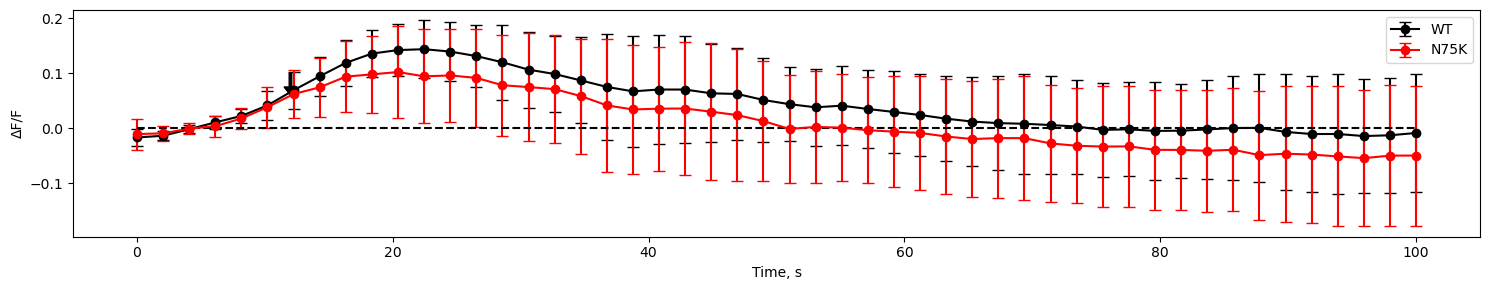

In [129]:
cfp_prof_con_mask_mean = np.mean(cfp_dist_prof_arr_con_mask, axis=0)
cfp_prof_con_mask_sd = np.std(cfp_dist_prof_arr_con_mask, axis=0)

yfp_prof_con_mask_mean = np.mean(yfp_dist_prof_arr_con_mask, axis=0)
yfp_prof_con_mask_sd = np.std(yfp_dist_prof_arr_con_mask, axis=0)


# plot for connected ROIs
plt.figure(figsize=prof_plot_size)

plt.errorbar(time_line, cfp_prof_con_mask_mean,
             yerr = cfp_prof_con_mask_sd,
             fmt ='-o', color='k', capsize=4, label='WT')
plt.errorbar(time_line, yfp_prof_con_mask_mean,
             yerr = yfp_prof_con_mask_sd,
             fmt ='-o', color='r', capsize=4, label='N75K')

plt.hlines(y=0, xmin=0, xmax=time_line.max(), linestyles='--', color='k')
plt.arrow(12, 0.1, 0, -0.025,  # X, Y, dX, dY
          width=0.2, color='k', head_width=1, head_length=0.015)

plt.xlabel('Time, s')
plt.ylabel('ΔF/F')
plt.tight_layout()
plt.legend()

Mutant mask profiles

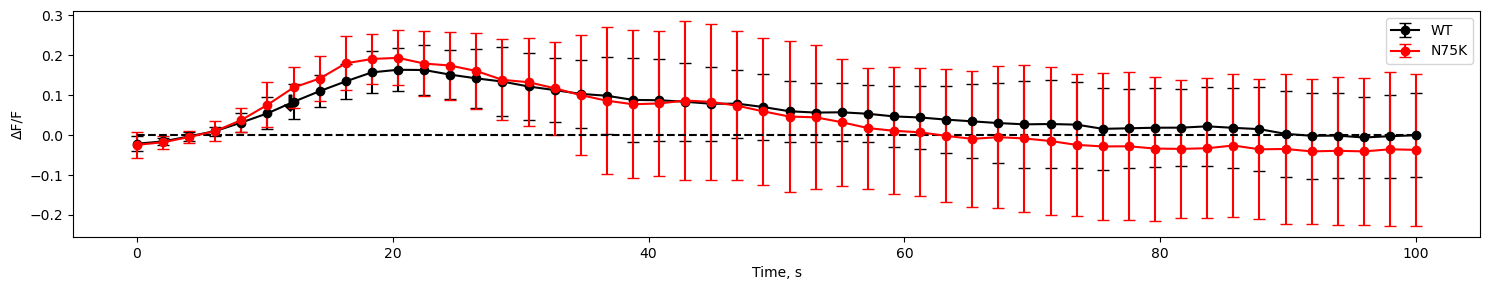

In [130]:
cfp_prof_yfp_mask_mean = np.mean(cfp_dist_prof_arr_mut_mask, axis=0)
cfp_prof_yfp_mask_sd = np.std(cfp_dist_prof_arr_mut_mask, axis=0)

yfp_prof_mean = np.mean(yfp_dist_prof_arr_mut_mask, axis=0)
yfp_prof_sd = np.std(yfp_dist_prof_arr_mut_mask, axis=0)


# plot for connected ROIs
plt.figure(figsize=prof_plot_size)

plt.errorbar(time_line, cfp_prof_yfp_mask_mean,
             yerr = cfp_prof_yfp_mask_sd,
             fmt ='-o', color='k', capsize=4, label='WT')
plt.errorbar(time_line, yfp_prof_mean,
             yerr = yfp_prof_sd,
             fmt ='-o', color='r', capsize=4, label='N75K')

plt.hlines(y=0, xmin=0, xmax=time_line.max(), linestyles='--', color='k')
plt.arrow(12, 0.1, 0, -0.025,  # X, Y, dX, dY
          width=0.2, color='k', head_width=1, head_length=0.015)

plt.xlabel('Time, s')
plt.ylabel('ΔF/F')
plt.tight_layout()
plt.legend()

Halo profiles

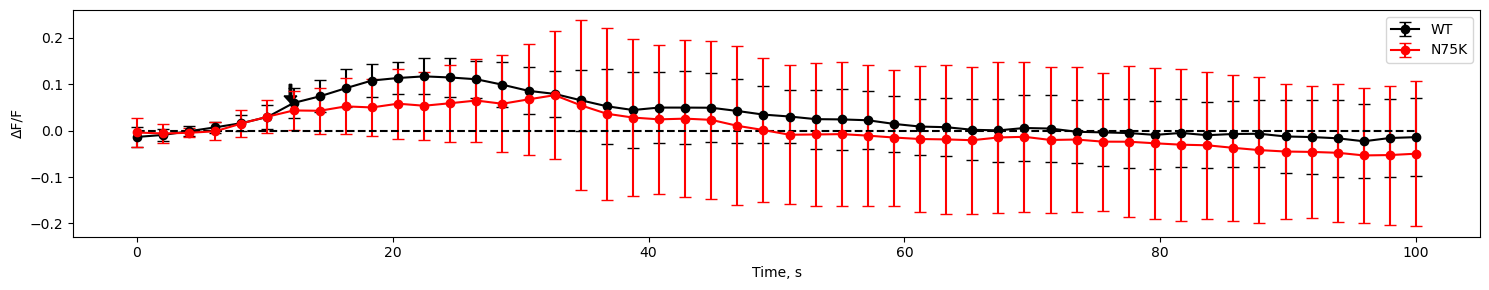

In [131]:
cfp_prof_hal_mask_mean = np.mean(cfp_dist_prof_arr_hal_mask, axis=0)
cfp_prof_hal_mask_sd = np.std(cfp_dist_prof_arr_hal_mask, axis=0)

yfp_prof_hal_mask_mean = np.mean(yfp_dist_prof_arr_hal_mask, axis=0)
yfp_prof_hal_mask_sd = np.std(yfp_dist_prof_arr_hal_mask, axis=0)


# plot for connected ROIs
plt.figure(figsize=prof_plot_size)

plt.errorbar(time_line, cfp_prof_hal_mask_mean,
             yerr = cfp_prof_hal_mask_sd,
             fmt ='-o', color='k', capsize=4, label='WT')
plt.errorbar(time_line, yfp_prof_hal_mask_mean,
             yerr = yfp_prof_hal_mask_sd,
             fmt ='-o', color='r', capsize=4, label='N75K')

plt.hlines(y=0, xmin=0, xmax=time_line.max(), linestyles='--', color='k')
plt.arrow(12, 0.1, 0, -0.025,  # X, Y, dX, dY
          width=0.2, color='k', head_width=1, head_length=0.015)

plt.xlabel('Time, s')
plt.ylabel('ΔF/F')
plt.tight_layout()
plt.legend()

## Stat

#### Max amplitude stat

In [132]:
wt_amp_prof = cfp_dist_prof_arr_mut_mask
mut_amp_prof = yfp_dist_prof_arr_mut_mask

max_frame = 10

wt_max_amp = wt_amp_prof[:, max_frame]
mut_max_amp = mut_amp_prof[:, max_frame]

print(len(wt_max_amp), len(mut_max_amp))

amp_u_test = stats.mannwhitneyu(wt_max_amp, mut_max_amp)
print(f"U-test p-val={round(amp_u_test[1], 5)}")

16 14
U-test p-val=0.17668


In [133]:
wt_amp_df = pd.DataFrame({'FP':np.full(len(wt_max_amp), 'WT'),
                           'amp':wt_max_amp})
mut_amp_df = pd.DataFrame({'FP':np.full(len(mut_max_amp), 'N75K'),
                           'amp':mut_max_amp})
amp_df = pd.concat([wt_amp_df, mut_amp_df], ignore_index=True)


fig = px.box(amp_df, x='FP', y='amp', color='FP', points='all',
             title=f'U-test p={round(amp_u_test[1], 3)}',
             labels={"amp": "ΔF/F", "FP": ""},
             color_discrete_sequence=['#000000', '#ff0000'])

fig.update_layout(height=600, width=300, showlegend=False, margin={'l':0, 'r':10, 't':40, 'b':0})
fig.show()

In [63]:
amp_df

,FP,amp
0,WT,0.057318
1,WT,0.052680
2,WT,0.045233
3,WT,0.059012
4,WT,0.064745
5,WT,0.047608
6,WT,0.069380
7,N75K,0.085909
8,N75K,0.095328
9,N75K,0.039300


#### Area stat

In [ ]:
def area_calc(input_labels):
    input_props = measure.regionprops(input_labels)
    output_areas = []
    for reg_prop in input_props:
        output_areas.append(reg_prop.area)

    return output_areas


cfp_up_areas = area_calc(cfp_up_label)
yfp_up_areas = area_calc(yfp_up_label)

cfp_area_df = pd.DataFrame({'FP':np.full(len(cfp_up_areas), 'WT'),
                           'area':cfp_up_areas})
yfp_area_df = pd.DataFrame({'FP':np.full(len(yfp_up_areas), 'N75K'),
                           'area':yfp_up_areas})
area_df = pd.concat([yfp_area_df, cfp_area_df], ignore_index=True)


print(len(cfp_up_areas))
print(len(yfp_up_areas))

area_u_test = stats.mannwhitneyu(cfp_up_areas, yfp_up_areas)
print(f"U-test p-val={round(area_u_test[1], 5)}")

fig = px.box(area_df, x='FP', y='area', color='FP', points='all', title=f'Up ROIs area in px, U-test p={round(area_u_test[1], 5)}')
fig.show()